### Notebook for the label transfer of Healthy Human Heart to mouse heart using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230918

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
absl                NA
aiohttp             3.8.5
aiosignal           1.3.1
annotated_types     0.5.0
anyio               NA
asttokens           NA
async_timeout       4.0.3
attr                23.1.0
backcall            0.2.0
backoff             2.2.1
bs4                 4.12.2
certifi             2023.07.22
charset_normalizer  3.2.0
chex                0.1.7
click               8.1.7
comm                0.1.4
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
deepdiff            6.3.1
docrep              0.3.2
etils               1.4.1
executing           1.2.0
fastapi             0.103.0
flax                0.7.2
frozenlist          1.4.0
fsspec              2023.6.0
h5py                3.9.0
idna                3.4
importlib_resources NA
ipykernel           6.25.1
ipywidgets        

In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [5]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [6]:
reference = sc.read_h5ad('../data/hca_heart_global_ctl230918_states_formatted.h5ad')
reference

AnnData object with n_obs × n_vars = 452506 × 22260
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

- Remove annotations with less than 10 cells

In [7]:
reference.obs['seed_labels'].value_counts()

seed_labels
vCM1             71162
PC1_vent         50095
EC1_cap          27417
FB1              26632
vCM2             25658
                 ...  
CD4+T_Th1           74
gdT                 24
NC6                 24
unclassfied.2       20
CD4+T_Th17           8
Name: count, Length: 79, dtype: int64

In [8]:
reference.obs['seed_labels'].cat.categories

Index(['Adip1', 'Adip2', 'Adip3', 'Adip4', 'B', 'B_plasma', 'CD14+Mo',
       'CD4+T_Tfh', 'CD4+T_Th1', 'CD4+T_Th17', 'CD4+T_Th2', 'CD4+T_act',
       'CD4+T_naive', 'CD4+T_reg', 'CD69+Mo', 'CD8+T_cytox', 'CD8+T_em',
       'CD8+T_te', 'CD8+T_trans', 'Cycling_T/NK', 'DC2', 'DOCK4+aMØ',
       'DOCK4+vMØ', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap',
       'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_atria', 'EC8_ln',
       'EC9_FB-like', 'FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6', 'ILC',
       'LYVE1+MØ1', 'LYVE1+MØ2', 'M2MØ', 'MAIT-like', 'Mast', 'Meso', 'MoMø',
       'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6', 'NK_CD16hi', 'NK_CD56hi',
       'NØ', 'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 'SMC1_basic',
       'SMC2_art', 'TREM2+MØ', 'aCM1', 'aCM2', 'aCM3', 'aCM4', 'aCM5', 'gdT',
       'nøMo', 'pDC', 'proIMØ', 'unclassfied.1', 'unclassfied.2', 'vCM1',
       'vCM2', 'vCM3', 'vCM4', 'vCM5'],
      dtype='object')

### Subset populations of interest

In [9]:
reference = reference[~reference.obs['seed_labels'].isin(['nan', 'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6', 'EC10_CMC-like', 'PC3_str', 'PC4_CMC-like'])]
reference.obs['seed_labels'].value_counts()

seed_labels
vCM1             71162
PC1_vent         50095
EC1_cap          27417
FB1              26632
vCM2             25658
                 ...  
pDC                 79
CD4+T_Th1           74
gdT                 24
unclassfied.2       20
CD4+T_Th17           8
Name: count, Length: 70, dtype: int64

In [10]:
sc.pp.filter_cells(reference, min_genes = 200)
sc.pp.filter_cells(reference, min_counts = 100)

In [11]:
reference.obs['cell_source'].value_counts()

cell_source
Harvard-Nuclei    158632
Sanger-Nuclei     157632
Sanger-CD45        70042
Sanger-Cells       43193
Name: count, dtype: int64

### Read in other query

In [12]:
query = sc.read_h5ad('../data/heart_mm_nuclei-23-0092_CB_QCed_ctl230918.raw.h5ad')
query.obs['cell_source'] = 'HIRI-Nuclei'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 143257 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [13]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [14]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [15]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 572756 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-refe

In [16]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
Unknown          143257
vCM1              71162
PC1_vent          50095
EC1_cap           27417
FB1               26632
                  ...  
pDC                  79
CD4+T_Th1            74
gdT                  24
unclassfied.2        20
CD4+T_Th17            8
Name: count, Length: 71, dtype: int64

In [17]:
adata.obs['batch'].value_counts()

batch
reference    429499
query        143257
Name: count, dtype: int64

### Select HVGs

In [18]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 572756 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-refer

### Transfer of annotation with scANVI

In [19]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [20]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [21]:
scvi_model.train(60, check_val_every_n_epoch = 1, enable_progress_bar = True, use_gpu = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 60/60: 100%|██████████| 60/60 [25:08<00:00, 23.94s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=1.95e+3]

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 60/60: 100%|██████████| 60/60 [25:08<00:00, 25.14s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=1.95e+3]


### Evaluate model performance a la _Sevensson_

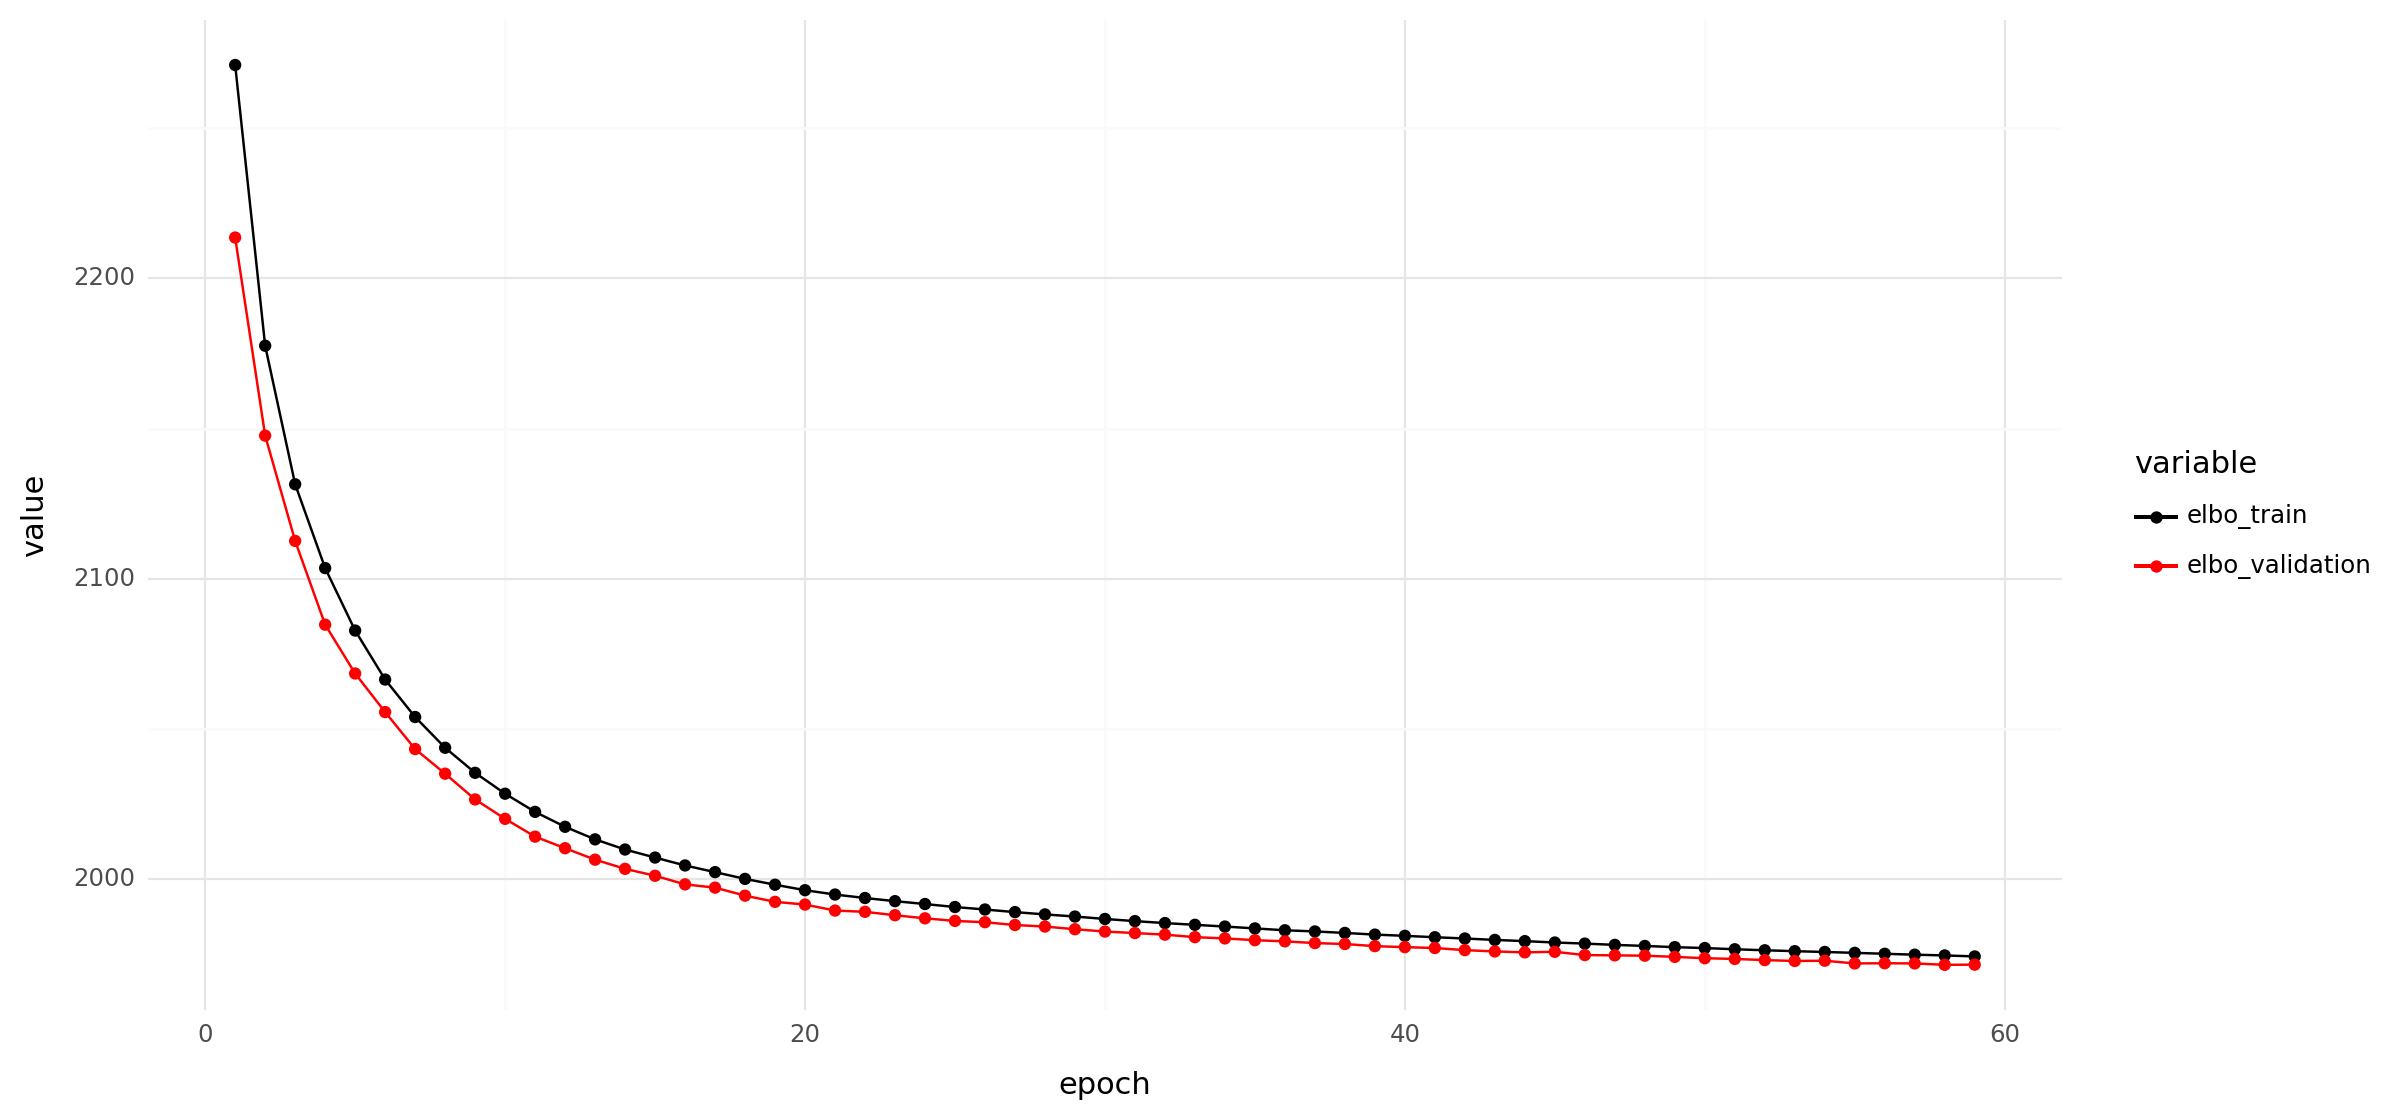

In [22]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [23]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [24]:
scanvi_model.train(150, check_val_every_n_epoch = 1, enable_progress_bar = True, use_gpu = 1)

INFO     Training for 150 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 33/150:  21%|██▏       | 32/150 [37:27<2:18:12, 70.27s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.12e+3]

### Evaluate model performance a la Svensson

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'sample', 'batch'], size = 1, legend_fontsize = 5, ncols = 3)

### Export annotated object

In [ ]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

In [ ]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

### Add new gene symbols

In [ ]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

### Revert gene symbols

In [ ]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

In [ ]:
query_export.obs['C_scANVI'].value_counts()

In [ ]:
query_export